In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import mplhep as hep
from jetnet.datasets import JetNet
from model.refinement import GNN, FCN, NodeFCN, GNN2, NodeFCN2
from model.mpgan.model import MPNet
plt.style.use(hep.style.CMS)

In [2]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [3]:
model = MPNet(30, 3, output_node_size=3)
# model = GNN()
# model = GNN2()
# model = FCN()
# model = NodeFCN()
# model = NodeFCN2()
model.load_state_dict(torch.load('refinement/models/MPNet_refinement.pt'))
# model.load_state_dict(torch.load('refinement/models/GNN_refinement.pt'))
# model.load_state_dict(torch.load('refinement/models/GNN2_refinement.pt'))
# model.load_state_dict(torch.load('refinement/models/FCN_refinement.pt'))
# model.load_state_dict(torch.load('refinement/models/NodeFCN_refinement.pt'))
# model.load_state_dict(torch.load('refinement/models/NodeFCN2_refinement.pt'))
model.cuda();
count_parameters(model)

348131

In [4]:
np.random.seed(99)
def load_gluon_dataset(dataroot):
    particle_data, jet_data = JetNet.getData(jet_type=["g"], data_dir=dataroot)
    particle_data = particle_data[..., :-1] # toss mask dimension
    dataset_size = 1000
    np.random.shuffle(particle_data)
    particle_data = particle_data[:dataset_size]
    m = particle_data.mean(axis=1).reshape(-1, 1, 3)
    s = particle_data.std(axis=1).reshape(-1, 1, 3)
    return particle_data * s + m

In [5]:
samples = torch.load('/diffusionvol/experiments/test_generation/pvd_gluons_bkup/syn/samples.pth')
# ref = torch.load('/diffusionvol/experiments/test_generation/pvd_gluons/syn/ref.pth')
ref = load_gluon_dataset('/diffusionvol/data/')
samples = samples.numpy()
# ref = ref.numpy()

In [6]:
_samples = []
bs = 256
for i in range(0, len(samples), bs):
    _samples.append(model(torch.tensor(samples[i:i+bs]).cuda()))
_samples = torch.cat(_samples)
_samples.shape

torch.Size([1000, 30, 3])

In [7]:
samples = _samples.detach().cpu().numpy()

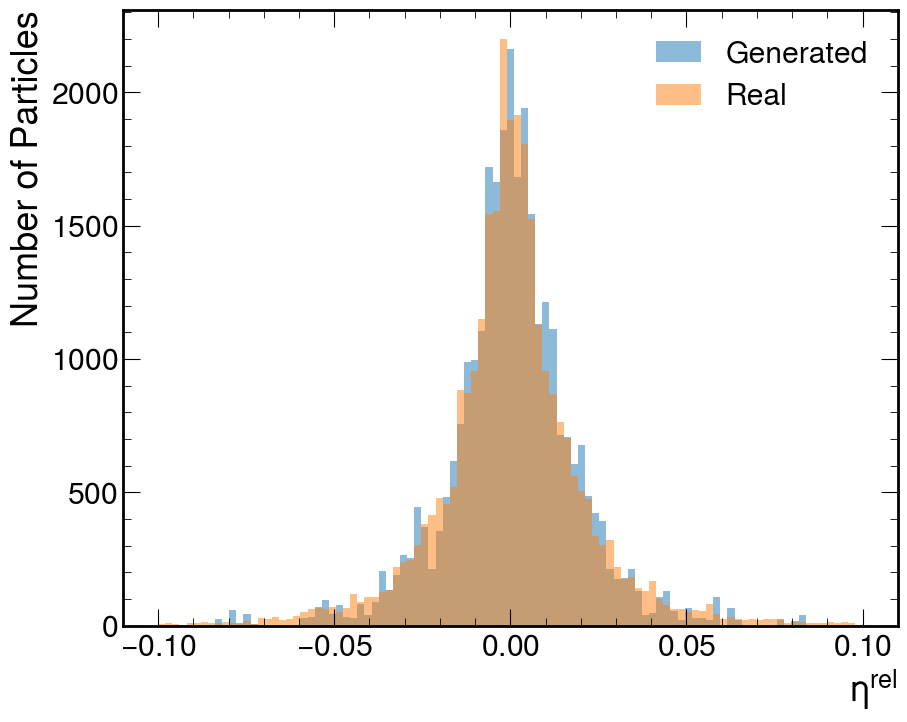

In [8]:
plt.figure(figsize=(10,8))
plt.hist(samples[..., 0].flatten(), bins=np.linspace(-0.1, 0.1, 100), alpha=0.5, label='Generated');
plt.hist(ref[..., 0].flatten(), bins=np.linspace(-0.1, 0.1, 100), alpha=0.5, label='Real');
plt.legend()
plt.ticklabel_format(useMathText=True)
plt.xlabel("$\eta^{rel}$")
plt.ylabel('Number of Particles')
plt.savefig('eta.png')
plt.show()

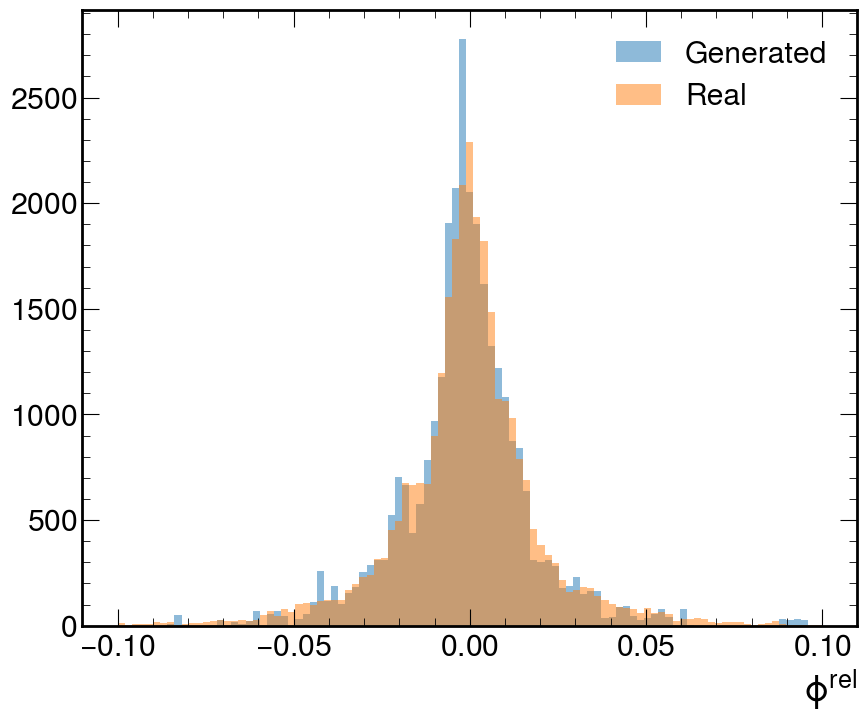

In [9]:
plt.style.use(hep.style.CMS)
plt.figure(figsize=(10,8))
plt.hist(samples[..., 1].flatten(), bins=np.linspace(-0.1, 0.1, 100), alpha=0.5, label='Generated');
plt.hist(ref[..., 1].flatten(), bins=np.linspace(-0.1, 0.1, 100), alpha=0.5, label='Real');
plt.legend()
plt.ticklabel_format(useMathText=True)
plt.xlabel("$\phi^{rel}$")
plt.savefig('phi.png')
plt.show()

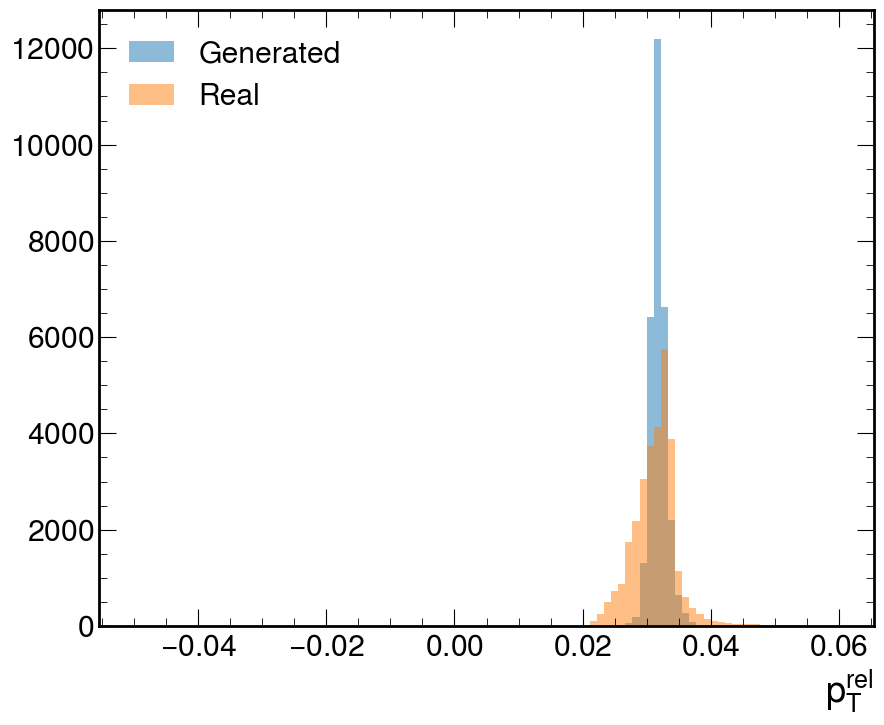

In [10]:
plt.style.use(hep.style.CMS)
plt.figure(figsize=(10,8))
plt.hist(samples[..., 2].flatten(), bins=np.linspace(-0.05, 0.06, 100), alpha=0.5, label='Generated');
plt.hist(ref[..., 2].flatten(), bins=np.linspace(-0.05, 0.06, 100), alpha=0.5, label='Real');
plt.legend()
plt.ticklabel_format(useMathText=True)
plt.xlabel("$p_T^{rel}$")
plt.savefig('pt.png')
plt.show()

In [11]:
from jetnet import evaluation

In [12]:
samples_pt_pos = samples
samples_pt_pos[..., -1] = samples_pt_pos[..., -1].clip(min=0)

In [13]:
cov, mmd = evaluation.cov_mmd(samples_pt_pos, ref)

Calculating cov and mmd over 10 batches: 100%|██████████| 10/10 [00:20<00:00,  2.03s/it]


In [14]:
print(f'COV: {cov}')
print(f'MMD: {mmd}')

COV: 0.372
MMD: 0.018053710182171032


In [15]:
w1efpm, w1efpstd = evaluation.w1efp(
    samples,
    ref,
    use_particle_masses=False,
    average_over_efps=True,
    return_std=True
)
print(w1efpm, w1efpstd)

1.2775752720456725e-07 2.74906266670983e-09


In [16]:
fpd = evaluation.fpnd(samples, jet_type='g')

/opt/conda/lib/python3.10/site-packages/jetnet/evaluation/gen_metrics.py:242: RuntimeWarning: Recommended number of jets for FPND calculation is 50000
  warnings.warn(
Running ParticleNet: 100%|██████████| 63/63 [00:00<00:00, 158.04it/s]


In [17]:
fpd

139.6343124408607